Partially moved to snakemake.

In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

# Custom functions
sys.path.insert(1, '../..')
%load_ext autoreload
%autoreload 2
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

from pathlib import Path
figure_path = Path('../../figures/')

In [27]:
def simul(mu=(2,-2), S=(5,3), D=30, N=1000, iterations=50, correction_factor=True, pca=False, do_zscore=True):
    from itertools import product
    D = [D] if type(D) is int else D
    N = [N] if type(N) is int else N
    evals = [x for x in product(D, N)]
    res = []
    for d, n in tqdm(evals):
        factor = (n/(n-1)) if correction_factor else 1
        for i in range(iterations):
            X = np.random.normal(mu[0], S[0], size=(n, d))
            Y = np.random.normal(mu[1], S[1], size=(n, d))
            if pca:
                from sklearn.decomposition import PCA
                from scipy.stats import zscore
                pca = PCA(n_components=np.min([n, 30]))
                XY = np.vstack([X,Y])
                Z = zscore(XY, axis=0) if do_zscore else XY
                pca.fit(Z)
                X = pca.transform(X)
                Y = pca.transform(Y)
            dxy = np.mean(pairwise_distances(X,Y, metric='sqeuclidean'))
            sx = np.mean(pairwise_distances(X,X, metric='sqeuclidean'))*factor
            sy = np.mean(pairwise_distances(Y,Y, metric='sqeuclidean'))*factor
            ed = 2*dxy-sx-sy
            res.append([ed, dxy, sx, sy, i, d, n])
    return pd.DataFrame(res, columns=['edistance', 'delta', 'sigma_x', 'sigma_y', 'iteration', 'dimension', 'sample_size'])

# Dimension has no impact

In [178]:
df = simul(mu=(2,-2), S=(5,3), D=np.arange(1,21), N=100, iterations=50)

100%|██████████| 20/20 [00:00<00:00, 38.80it/s]


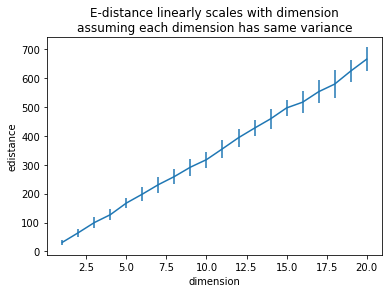

In [179]:
# since PCA will try to represent to overall variance in the data, this is not bad at all!
pl.errorbar(np.arange(1,21), df.groupby('dimension').mean().edistance, yerr=df.groupby('dimension').std().edistance)
pl.xlabel('dimension')
pl.ylabel('edistance')
pl.title('E-distance linearly scales with dimension\nassuming each dimension has same variance')
pl.show()

# Convergence speed of E-distance with sample size depends on variance

In [200]:
N = [2,5,20,50,200,500,2000]
df_low = simul(mu=(2,-2), S=(5,3), D=30, N=N, iterations=50, correction_factor=True)
df_high = simul(mu=(2,-2), S=(10,50), D=30, N=N, iterations=50, correction_factor=True)

100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


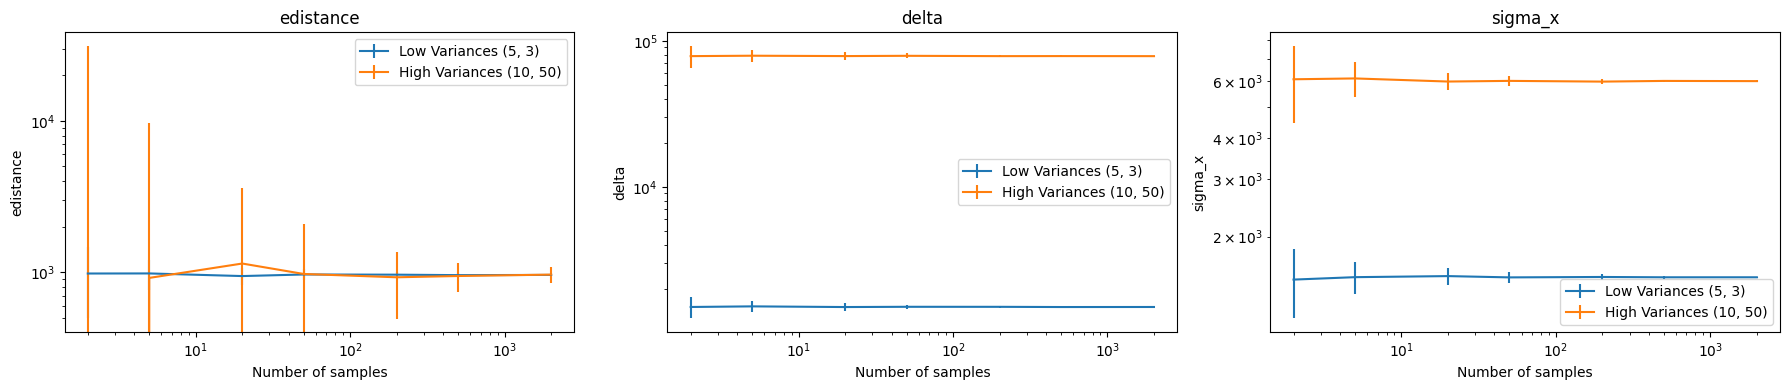

In [201]:
keys = ['edistance', 'delta', 'sigma_x']
fig, axs = pl.subplots(1, len(keys), figsize=(6*len(keys), 4), dpi=100)
for ax, key in zip(axs, keys):
    ax.errorbar(N, df_low.groupby('sample_size').mean()[key], 
                yerr=df_low.groupby('sample_size').std()[key], 
                label=f'Low Variances {low_sigmas}')
    ax.errorbar(N, df_high.groupby('sample_size').mean()[key], 
                yerr=df_high.groupby('sample_size').std()[key], 
                label=f'High Variances {high_sigmas}')
    ax.set_xlabel('Number of samples')
    ax.set_ylabel(key)
    ax.set_title(f'{key}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
pl.tight_layout()
pl.show()

## D=1

In [209]:
N = [2,5,20,50,200,500,2000]
df_low = simul(mu=(2,-2), S=(5,3), D=1, N=N, iterations=50, correction_factor=True)
df_high = simul(mu=(2,-2), S=(10,50), D=1, N=N, iterations=50, correction_factor=True)

100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


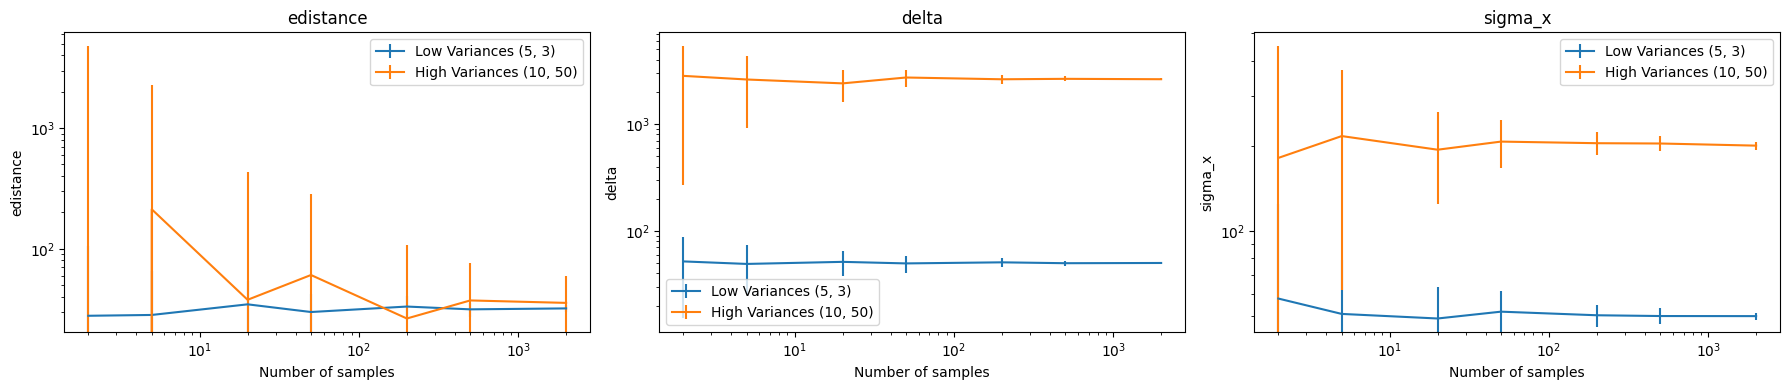

In [210]:
# since PCA will try to represent to overall variance in the data, this is not bad at all!
keys = ['edistance', 'delta', 'sigma_x']
fig, axs = pl.subplots(1, len(keys), figsize=(6*len(keys), 4), dpi=100)
for ax, key in zip(axs, keys):
    ax.errorbar(N, df_low.groupby('sample_size').mean()[key], 
                yerr=df_low.groupby('sample_size').std()[key], 
                label=f'Low Variances {low_sigmas}')
    ax.errorbar(N, df_high.groupby('sample_size').mean()[key], 
                yerr=df_high.groupby('sample_size').std()[key], 
                label=f'High Variances {high_sigmas}')
    ax.set_xlabel('Number of samples')
    ax.set_ylabel(key)
    ax.set_title(f'{key}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
pl.tight_layout()
pl.show()

## Uncorrected

In [202]:
N = [2,5,20,50,200,500,2000]
df_low = simul(mu=(2,-2), S=(5,3), D=30, N=N, iterations=50, correction_factor=False)
df_high = simul(mu=(2,-2), S=(10,50), D=30, N=N, iterations=50, correction_factor=False)

100%|██████████| 7/7 [00:08<00:00,  1.21s/it]


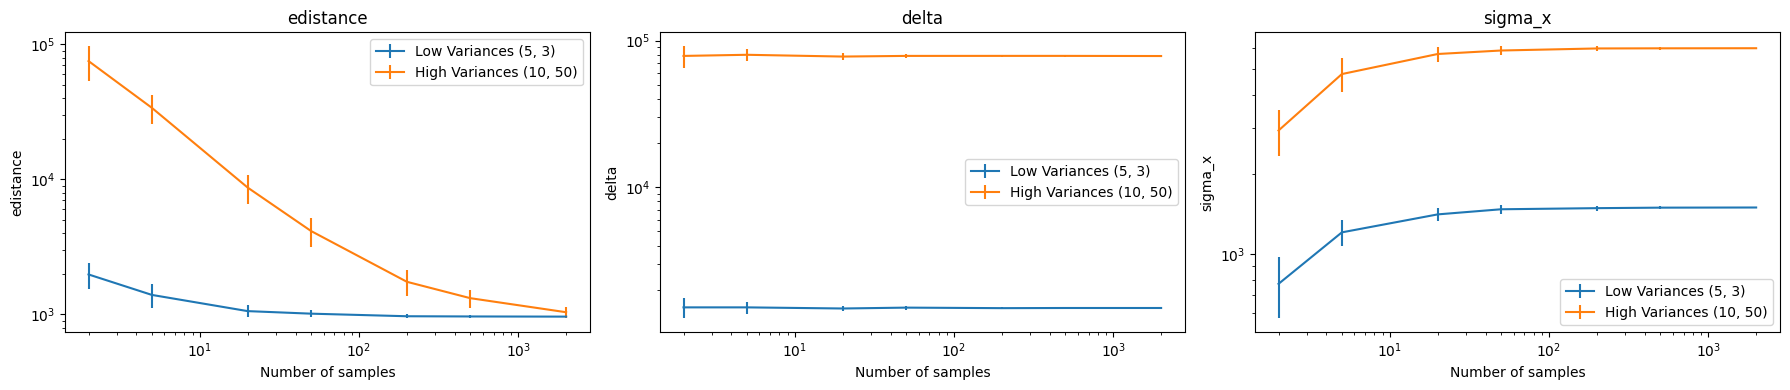

In [203]:
# since PCA will try to represent to overall variance in the data, this is not bad at all!
keys = ['edistance', 'delta', 'sigma_x']
fig, axs = pl.subplots(1, len(keys), figsize=(6*len(keys), 4), dpi=100)
for ax, key in zip(axs, keys):
    ax.errorbar(N, df_low.groupby('sample_size').mean()[key], 
                yerr=df_low.groupby('sample_size').std()[key], 
                label=f'Low Variances {low_sigmas}')
    ax.errorbar(N, df_high.groupby('sample_size').mean()[key], 
                yerr=df_high.groupby('sample_size').std()[key], 
                label=f'High Variances {high_sigmas}')
    ax.set_xlabel('Number of samples')
    ax.set_ylabel(key)
    ax.set_title(f'{key}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
pl.tight_layout()
pl.show()

# Including PCA

In [31]:
N = [2,5,20,50,200,500,2000]
df_low = simul(mu=(2,-2), S=(5,3), D=2000, N=N, iterations=50, correction_factor=False, pca=True)
df_high = simul(mu=(2,-2), S=(10,50), D=2000, N=N, iterations=50, correction_factor=False, pca=True)

100%|██████████| 7/7 [01:06<00:00,  9.49s/it]


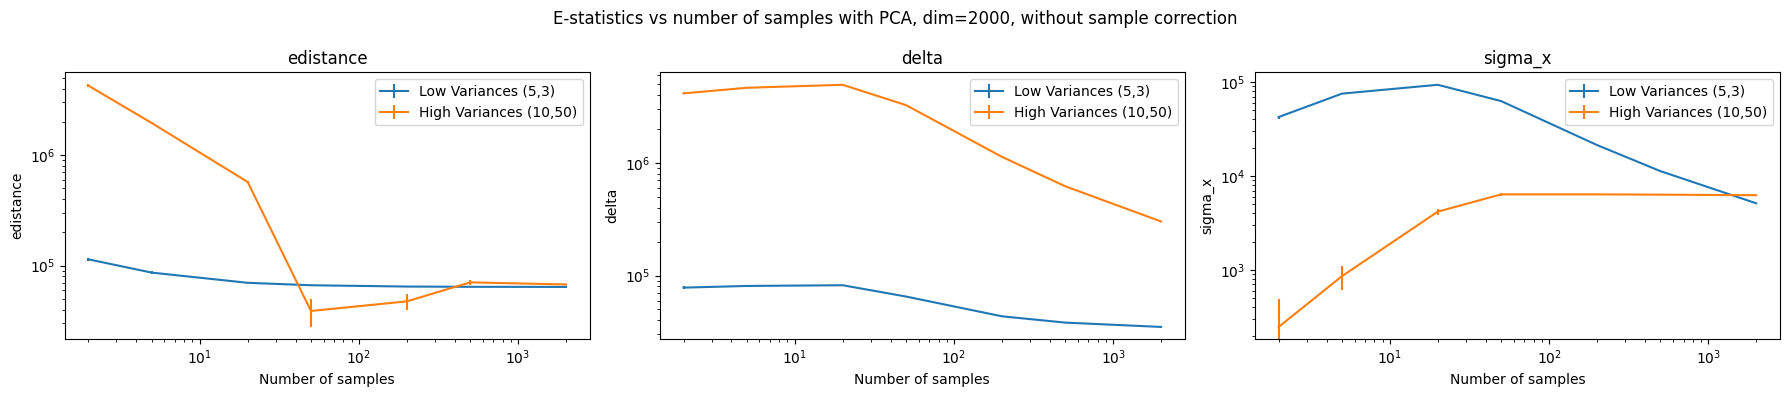

In [32]:
# since PCA will try to represent to overall variance in the data, this is not bad at all!
keys = ['edistance', 'delta', 'sigma_x']
fig, axs = pl.subplots(1, len(keys), figsize=(6*len(keys), 4), dpi=100)
for ax, key in zip(axs, keys):
    ax.errorbar(N, df_low.groupby('sample_size').mean()[key], 
                yerr=df_low.groupby('sample_size').std()[key], 
                label=f'Low Variances (5,3)')
    ax.errorbar(N, df_high.groupby('sample_size').mean()[key], 
                yerr=df_high.groupby('sample_size').std()[key], 
                label=f'High Variances (10,50)')
    ax.set_xlabel('Number of samples')
    ax.set_ylabel(key)
    ax.set_title(f'{key}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
pl.suptitle(f'E-statistics vs number of samples with PCA, dim=2000, without sample correction')
pl.tight_layout()
pl.show()

In [33]:
N = [2,5,20,50,200,500,2000]
df_low = simul(mu=(2,-2), S=(5,3), D=2000, N=N, iterations=50, correction_factor=True, pca=True)
df_high = simul(mu=(2,-2), S=(10,50), D=2000, N=N, iterations=50, correction_factor=True, pca=True)

100%|██████████| 7/7 [01:06<00:00,  9.45s/it]


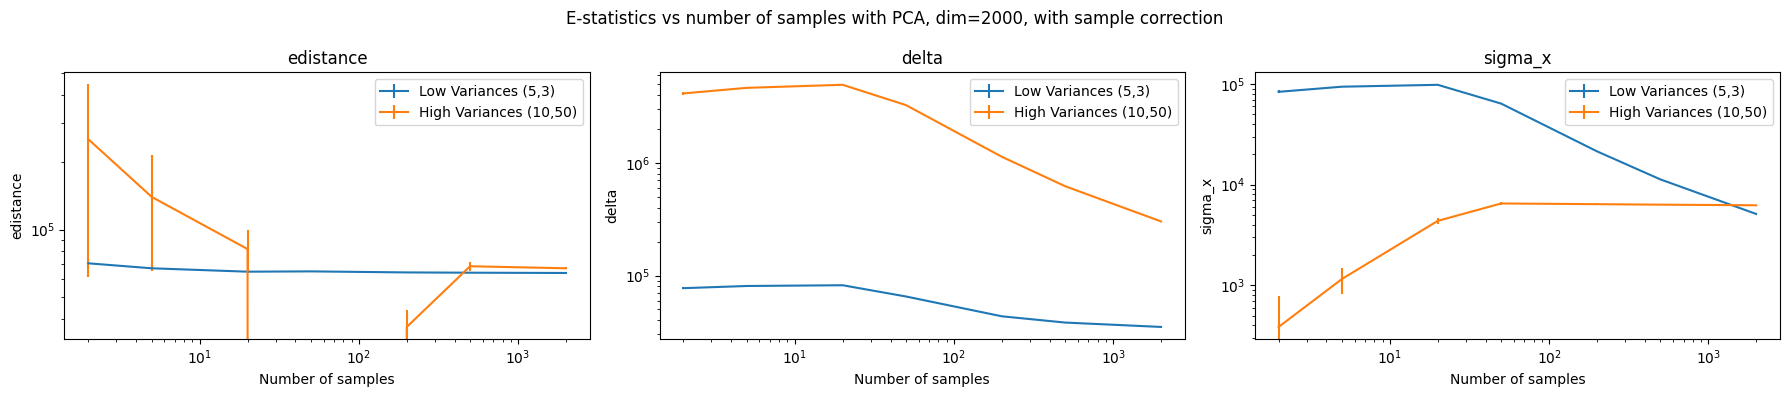

In [34]:
# since PCA will try to represent to overall variance in the data, this is not bad at all!
keys = ['edistance', 'delta', 'sigma_x']
fig, axs = pl.subplots(1, len(keys), figsize=(6*len(keys), 4), dpi=100)
for ax, key in zip(axs, keys):
    ax.errorbar(N, df_low.groupby('sample_size').mean()[key], 
                yerr=df_low.groupby('sample_size').std()[key], 
                label=f'Low Variances (5,3)')
    ax.errorbar(N, df_high.groupby('sample_size').mean()[key], 
                yerr=df_high.groupby('sample_size').std()[key], 
                label=f'High Variances (10,50)')
    ax.set_xlabel('Number of samples')
    ax.set_ylabel(key)
    ax.set_title(f'{key}')
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
pl.suptitle(f'E-statistics vs number of samples with PCA, dim=2000, with sample correction')
pl.tight_layout()
pl.show()